In [63]:
! pip install CASTING

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 158.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.3 which is incompatible.
cegann 0.1.1 requires numpy==1.21.5, but you have numpy 1.24.3 which is incompatible.
cegann 0.1.1 requires scikit_learn==1.2.1, but you have scikit-learn 1.0.2 which is incompatible.


### copying the potential file

A potential function is needed to define the interaction between the atoms. We will use an embedded atom model for this case.

In [1]:
import requests
url = "https://github.com/sbanik2/CASTING/raw/main/example/Au.eam"
r = requests.get(url, allow_redirects=True)
open('Au.eam', 'wb').write(r.content)

1790882

#### Import the modules

In [2]:
import random
import numpy as np
from CASTING.utilis import r_datafame,get_lattice
from CASTING.MCTS import MCTS
from CASTING.clusterfun import createRandomData
from CASTING.aseEamEvaluate import AseEamEvaluator
from CASTING.perturb import perturbate
from CASTING.writer import StructureWriter
from pymatgen.io.vasp.inputs import Poscar
from CASTING.clusterfun import  parm2struc

In [3]:

seed = 20

random.seed(seed)
np.random.seed(seed)


### Define the system and constrains

We are working with a non-periodic cluster system, and certain constraints must be maintained. These constraints include the minimum interatomic distance, the size of the simulation box, and the amount of perturbation to do ----

In [4]:


r_min = {"Au-Au":2}
r_max = {"Au-Au":4}
box_dim = 50 # Make sure there is enough vaccum in the sides

#--------crystal constrains-----------

constrains = {
    "composition":{"Au":1},
    "atoms":13,
    "r_min":r_datafame(r_min),
    "r_max":r_datafame(r_max),
    "lattice":get_lattice(box_dim),  
    }


#-------------perturbation------------


pt = {
    'max_mutation': 0.05,  #Put in fraction of the box length 0.01 means 100*0.01 =1Angs
}



    
ase_par = {
    'constrains':constrains,
    'par_file': "Au.eam", 
}
    




### Generate initial random structure

The root node or the starting point, is a random configuration ---

In [5]:
rootdata = createRandomData(constrains,multiplier= 10)

##### save the initial configuration in POSCAR format

In [6]:
Poscar(parm2struc(rootdata,constrains)).write_file('init.POSCAR')

### Define calculator

We need to define the calculator that evaluates the energy  ---

In [7]:
perturb = perturbate(**pt). perturb
evaluator = AseEamEvaluator(**ase_par).evaluate

### Launch MCTS

In [8]:
MCTS(
    rootdata,
    perturb ,
    evaluator,
    niterations=35,
    headexpand=10,
    nexpand=3,
    nsimulate=3,
    nplayouts=10,
    exploreconstant=1,
    maxdepth=12,
    a=0,
    selected_node=0,
)

total evaluations: 44, best score yet : -41.50836203346579
total evaluations: 77, best score yet : -41.50836203346579
total evaluations: 110, best score yet : -41.50836203346579
total evaluations: 143, best score yet : -41.50836203346579
total evaluations: 176, best score yet : -41.53183941188006
total evaluations: 209, best score yet : -41.53183941188006
total evaluations: 242, best score yet : -41.53183941188006
total evaluations: 275, best score yet : -41.53183941188006
total evaluations: 308, best score yet : -41.53184002526079
total evaluations: 341, best score yet : -41.53184002526079
total evaluations: 374, best score yet : -41.71028262617432
total evaluations: 407, best score yet : -41.71028262617432
total evaluations: 440, best score yet : -41.71028262617432
total evaluations: 473, best score yet : -41.71028262617432
total evaluations: 506, best score yet : -41.71028262617432
total evaluations: 539, best score yet : -41.71028262617432
total evaluations: 572, best score yet : -

### write the final configuration

In [9]:
from CASTING.writer import StructureWriter


num_to_write = 1 
writer = StructureWriter("dumpfile.dat",outpath="./",objfile="energy.dat",file_format="poscar") # "poscar" or "cif"
writer.write( num_to_write, sort=True) # sort to arrange in increasing order of energy


1it [00:00, 462.18it/s]


#### Evolution of error

In [23]:
import matplotlib.pyplot as plt

data =  open('dumpfile.dat','r').readlines()

enrgs = []
minval = 1e300


for line in data:
    col = line.split('|')
    eng = float(col[-1])
    if eng < minval:
        enrgs.append(eng)
        minval = eng
    else:
        enrgs.append(minval)
        

Text(0, 0.5, 'E (ev/atom)')

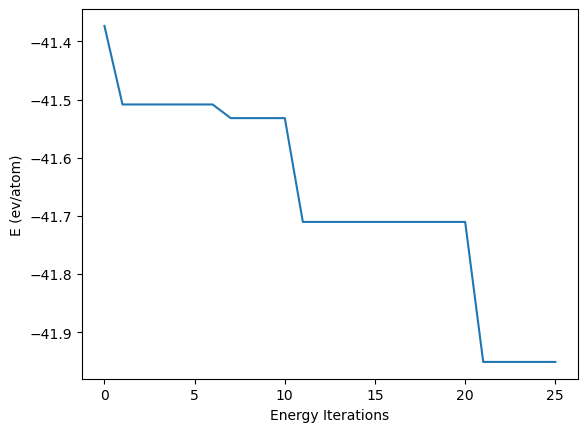

In [22]:
plt.plot(list(range(len(enrgs))),enrgs)
plt.xlabel('Energy Iterations')
plt.ylabel('E (ev/atom)')